# <center>Scaling XGBoost Hyper-Parameter Optimization</center>

<img src="images/swarm.png" width="550"/>

# Motivation:

To reach highest performance in classification tasks (i.e., supervised learning ), it is best practice to build an ensemble of champion models. 

Each member of the ensemble is a winner of a search over many models of its kind with altered hyper-parameters.

In this notebook, we build a harness for running such a [hyper-parameter] search to demonstrate the accuracy benefits while exploring performance as we scale within and accross GPU nodes.

# Library Imports:

In [1]:
import ipyvolume as ipv
import matplotlib.pyplot as plt

import cudf
import cuml
import numpy as np
import pandas as pd
import xgboost

import dask
from dask import delayed
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, LocalCluster, worker, as_completed
from dask_kubernetes import KubeCluster
import yaml

import data_utils
import swarm
import visualization as viz

# reload library modules/code without a kernel restart
import importlib; importlib.reload( swarm ); importlib.reload( data_utils ); importlib.reload( viz);
# ignore warnings
import warnings; warnings.filterwarnings('ignore')

-------

# PART 1 - Data Ingestion / Generation

-------

<center><a href='images/datasets.png'><img src="images/datasets.png" width="800"/></a></center>

# 0. Load Saved Configuration / Experiment
> To start a new experiment set `savedExperimentFilename = None`

> Otherwise set its value to the path of a previously saved experiment [ yaml format ].

In [2]:
savedExperimentFilename = None # 'experiment.yaml'
exp, loadingSavedExperiment = data_utils.load_saved_experiment ( savedExperimentFilename )

starting new experiment


In [3]:
exp

{}

# 1. Data

In this notebook you can try different hyper-parameter search methods using synthetic or real data.

In [4]:
if not loadingSavedExperiment:
    
    datasetConfig = {  
        'datasetName'  : 'synthetic-swirl', #synthetic-helix', 'fashion-mnist', 'airline'
        'nSamples'     : 2000000,
        'localSaveDir' : './data/'
    }    

### 1.1 Additional parameters are available for synthetic data

In [5]:
if not loadingSavedExperiment:
    
    if 'synthetic' in datasetConfig['datasetName']:
        coilType = datasetConfig['datasetName'].split('-')[1]
        syntheticDetails = {
            'coilType'            : coilType,
            'coilDensity'         : 18 if coilType == 'swirl' else 9,
            'coil1StDev'          : .3,
            'coil2StDev'          : .3,
            'nGuidePointsPerCoil' : 1000,
            'shuffleFlag'         : True,
            'randomSeed'          : 0,
        }
        datasetConfig.update(syntheticDetails)

        # warmup - JIT compile data generation GPU kernels
        warmupConfig = datasetConfig.copy();
        warmupConfig['nSamples'] = 2
        data_utils.Dataset ( warmupConfig )     

## 1.2 -  Load/Generate Data based on Configuration

In [6]:
%%time
dataset = data_utils.Dataset ( datasetConfig ) 

CPU times: user 28.8 ms, sys: 8.37 ms, total: 37.1 ms
Wall time: 35.9 ms


In [7]:
dataset.data.shape

(2000000, 3)

# 2. Data Transformations

> **Splitting**: As is typical in machine learning workflows we need to split the dataset into a **train-set** and **test-set**. The test-set is unseen during training and model performance on the test-set is an indicator of how well our model(s) can generalize to future data [ also unseen during training ].

> **Scaling**: We can also apply standard scaling to each feature column of the dataset to ensure the data is numerically centered and ready for ingestion by an upstream model.
**Note**: This is an inplace operation which changes the value of the argument dataframe passed in without returning a value.


In [8]:
if not loadingSavedExperiment:

    dataTransformsConfig =  { 
        'standardScaling'   : True,
        'percentTrainSplit' : .75,
        'shuffleAtSplit'    : True,
        'randomSeed'        : 0
    }

> **Synthetic Splits**:  In the case of synthetic data, we use test with a distribution different than that of the train set in order to increase the difficulty of the problem and make it a challenge worthy of HPO. Specifically, we carve out the middle of the dataset along one of the synthetic dimensions [ x ], and assign these points to the test-set.

In [9]:
if not loadingSavedExperiment:
    
    if 'synthetic' in datasetConfig['datasetName'] :    
        dataTransformsConfig['percentTrainSplit'] = .75 if datasetConfig['coilType'] == 'swirl' else .885
        dataTransformsConfig['samplesToSwap']     = int( dataset.data.shape[0] * .002 )
        assert ( dataset.data.shape[0] == datasetConfig['nSamples'])

## 2.1 - Apply Data Transforms

In [10]:
%%time
# fill missing values
missingIndicator = 0
dataset.data = dataset.data.fillna( missingIndicator )

CPU times: user 5.93 ms, sys: 969 µs, total: 6.9 ms
Wall time: 5.35 ms


In [11]:
%%time
if 'synthetic' not in datasetConfig['datasetName']:
    
    trainData, testData, \
    trainLabels, testLabels = cuml.train_test_split( dataset.data,  dataset.labels, 
                                                     train_size = dataTransformsConfig['percentTrainSplit'] )    
else:
    trainData, testData, \
    trainLabels, testLabels = data_utils.split_synthetic ( dataset.data, dataset.labels, 
                                                           percentTrain = dataTransformsConfig['percentTrainSplit'], 
                                                           samplesToSwap = dataTransformsConfig['samplesToSwap'] )

dataset.assign_dataset_splits ( trainData, testData, trainLabels, testLabels )

splitting synthetic dataset into train-set 75.0% and test-set 25.0%
> assigning middle span of data to test-set
> swapping 4000 samples between train-set and test-set
CPU times: user 257 ms, sys: 28.1 ms, total: 285 ms
Wall time: 285 ms


In [12]:
%%time
# apply standard scaling inplace to train-set and test-set
trainMeans, trainSTDevs, _ = data_utils.scale_dataframe_inplace ( dataset.trainData, label='train-set', datasetObject = dataset )
_,_,_ = data_utils.scale_dataframe_inplace ( dataset.testData, trainMeans, trainSTDevs, label='test-set', datasetObject = dataset )

applying [inplace] standard scaling to train-set data
applying [inplace] standard scaling to test-set data
CPU times: user 13.4 ms, sys: 4.7 ms, total: 18.1 ms
Wall time: 16.4 ms


# 3. Visualize in 3D [ Embed ]

In [13]:
embeddingOptions = {
    'PCA'  : { 'method': 'PCA', 'sampleLimit': 200000 },
    'UMAP' : { 'method': 'UMAP', 'sampleLimit': 15000 },    
}

In [14]:
if not loadingSavedExperiment:
    
    vizConfig = {
        'maxSamplesToPlot' : 200000,
        'embedding'        : embeddingOptions['UMAP']
    }    

In [15]:
viz.plot_data_train_vs_test( dataset, vizConfig )

shuffling and decimating - train-set ... test-set ...
computing feature distributions in 0.72 seconds
elapsed time : 1.0446038246154785


-------

# PART 2 - Model and Parameter Intro

-------

# 4. Manual Hyper-Parameter Choice [ a.k.a., Can you beat HPO? ]

In [16]:
# flexible parameters -- read more @ https://xgboost.readthedocs.io/en/latest/parameter.html

manualXGBoostParams = { 
    'max_depth': 6,                     # default = 6             :: maximum depth of a tree
    'num_boost_round': 100,              # default = XXX           :: number of trees        
    'learning_rate': 0.3,               # default = 0.3           :: step size shrinkage between rounds, prevents overfitting
    'gamma': 0.,                        # default = 0             :: minimum loss reduction required to make a leaf node split, prevents overfitting
    'lambda': 1.,                       # default = 1             :: L2 regularizaiton term on weights, prevents overfitting
    'alpha': 0.,                        # default = 0             :: L1 regularization term on weights, prevents overfitting
    'tree_method': 'gpu_hist',          # default = 'gpu_hist'    :: tree construction algorithm
    'random_state' : 0 
}
# note: we'll inherit objective function [ & num_class ] from the dataset

In [17]:
trainedGPUModel, trainTimeGPU, inferenceTimeGPU = swarm.evaluate_manual_params( dataset, manualXGBoostParams )

train accuracy : 0.9326 in 0.7059 seconds
test  accuracy : 0.8701 in 0.0099 seconds


In [18]:
runCPUComparison = False
if runCPUComparison:
    trainedCPUModel, trainTimeCPU, inferenceTimeCPU = swarm.evaluate_manual_params_CPU ( dataset, manualXGBoostParams, nCPUWorkers = 4 )
    print( f' train speedup     : {trainTimeCPU / trainTimeGPU:0.2f} ' )
    print( f' inference speedup : {inferenceTimeCPU / inferenceTimeGPU:0.2f} ' )

train accuracy : 0.9325 in 13.8352 seconds
test  accuracy : 0.8329 in 0.6615 seconds
 train speedup     : 19.60 
 inference speedup : 66.50 


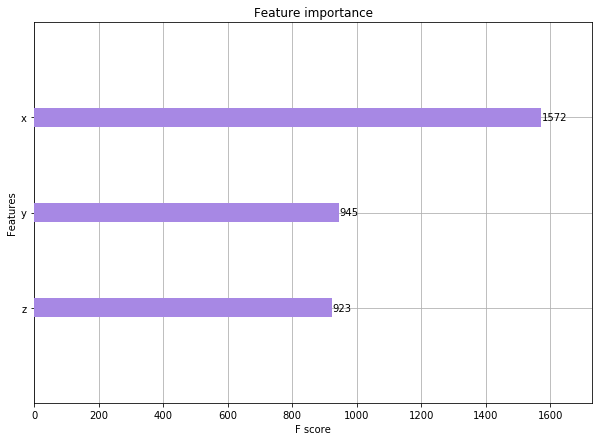

In [19]:
viz.plot_feature_importance( trainedGPUModel )

(500, 34)
CPU times: user 651 ms, sys: 233 ms, total: 885 ms
Wall time: 1.81 s


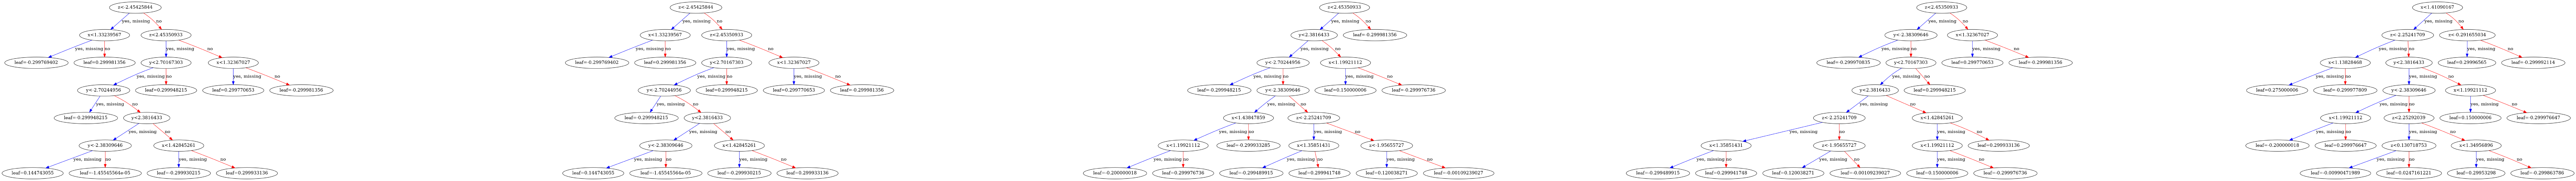

In [20]:
%%time
modelDetailPlots = False

if modelDetailPlots: 
    viz.plot_first_N_trees( trainedGPUModel, nTrees = 2 )

# 5. Model Settings for HPO and Parameter Search Ranges

> **Note**: number of trees will be allowed to freely range between 0-2000 with an early stopping settting of 250

In [21]:
if not loadingSavedExperiment:
    
    modelConfig = {
        'name'                  : 'XGBoost',    
                                  # parameter        low    high    dtype 
        'tunableParam1'         : ['max_depth',      2,     15,    'int'   ],
        'tunableParam2'         : ['learning_rate',  .001,  2,     'float' ],
        'tunableParam3'         : ['gamma',          0.,    3.,    'float' ],

        'nTrees-ceiling'        : 2000,
        'early-stopping-rounds' : 250,
        'randomSeed'            : 0,    
    }

-------

# PART 3 - Hyper Parameter Optimization

-------

## <center> Scaling Compute with Kubernetes and Dask</center>

<center><img src='images/scaling.png' width='1000px'></center>

## <center> Sync vs Async [ Dask Task Stream ] </center>

<center><img src='images/sync_vs_async.png' width='800px'></center>

# 6. Compute Cluster

In [22]:
if not loadingSavedExperiment:
    
    computeConfig = {
        'clusterType' : 'LocalCUDACluster', # LocalCUDACluster # KubeCluster
        'nWorkers'     : 4
    }

In [23]:
if computeConfig['clusterType'] == 'KubeCluster':
    kubeIP = !echo $KUBEFLOW_CONTROLLER_SERVICE_HOST
    if kubeIP[0] == '':
        assert("Kubernetes cluster not found! [ launch notebook from a Kubeflow Notebook Server ]")
        workerSpecFilename = None
    else:
        workerSpecFilename = 'k8s_dask_worker.yaml'
        print(f'successfully detected kubernetes controller @ {kubeIP}')
        print(f'k8s+dask workers will run pod spec defined in [ {workerSpecFilename} ]')
        swarm.build_worker_spec( workerSpecFilename )
        !cat $workerSpecFilename

In [24]:
if computeConfig['clusterType'] == 'LocalCUDACluster': # multi-GPU [ within a node ]
    cluster = LocalCUDACluster( ip = '', n_workers = computeConfig['nWorkers'])
    
elif computeConfig['clusterType'] == 'LocalCluster': # CPU
    cluster = LocalCluster( ip = '', n_workers = computeConfig['nWorkers'])
    
elif computeConfig['clusterType'] == 'KubeCluster': # multi-node multi-GPU
    cluster = KubeCluster.from_yaml( workerSpecFilename )

In [25]:
cluster

In [26]:
client = Client( cluster, asynchronous = True)

# 7. HPO Strategy

>  Particle Swarm vs Random Search 

> Synchronous vs Asynchronous

[1] https://en.wikipedia.org/wiki/Particle_swarm_optimization#Algorithm

In [27]:
if not loadingSavedExperiment:
    
    HPOConfig = { 
        'strategy'        : 'sync', # sync # async # async-random
        'nParticles'      : 16,
        'nEpochs'         : 10,
        'asyncWarmupFlag' : False,
        'randomSeed'      : 0
    }

# 8. Run Experiment

In [28]:
if HPOConfig['strategy'] == 'sync':
    expSwarm = swarm.SyncSwarm( client, dataset, HPOConfig, modelConfig, computeConfig )
    expSwarm.run_search()
    
elif HPOConfig['strategy'] == 'async':
    expSwarm = swarm.AsyncSwarm( client, dataset, HPOConfig, modelConfig, computeConfig )    
    expSwarm.run_search( syncWarmupFlag = HPOConfig['asyncWarmupFlag'] )
    
elif HPOConfig['strategy'] == 'async-random':
    expSwarm = swarm.RandomSearchAsync( client, dataset, HPOConfig, modelConfig, computeConfig )    
    expSwarm.run_search()

! initializing SyncSwarm, with 16 particles, and 10 epochs

   pID |      max_depth,  learning_rate,          gamma
     0 |              2,           0.00,           0.00 
     1 |              7,           1.87,           3.00 
     2 |             10,           1.86,           1.45 
     3 |             12,           1.68,           1.71 
     4 |             12,           0.35,           1.83 
     5 |              5,           1.66,           2.94 
     6 |             12,           0.42,           1.11 
     7 |              6,           0.88,           2.93 
     8 |              5,           0.48,           2.45 
     9 |             14,           0.99,           0.43 
    10 |             11,           0.99,           2.50 
    11 |             11,           1.33,           2.78 
    12 |             13,           1.75,           2.17 
    13 |              4,           1.72,           0.54 
    14 |             13,           1.32,           0.45 
    15 |             15,     

In [29]:
# TODO: Describe how to enable GPU Utilization and Memory Profiling as well as Dask Task Stream [ RAPIDS Jupyter Lab Plugins]

## 8.1 - Visualize Swarm

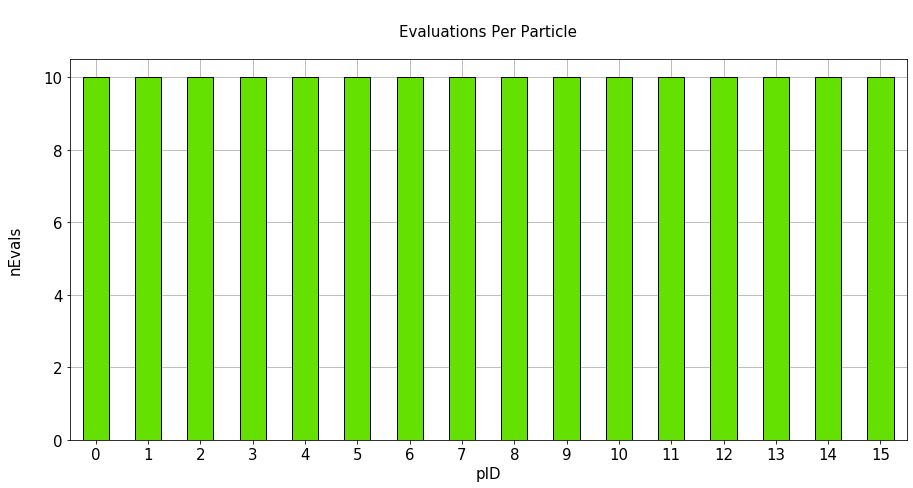

In [30]:
viz.plot_particle_evals( expSwarm )

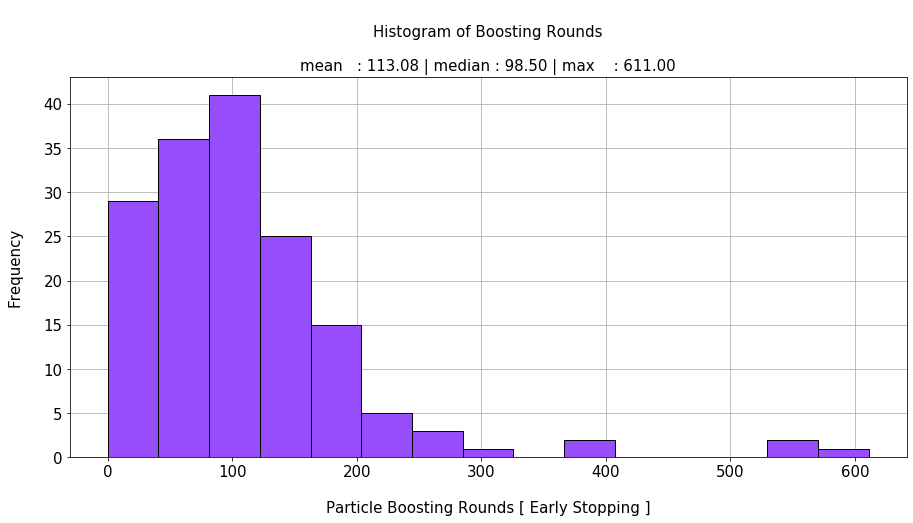

In [31]:
viz.plot_boosting_rounds_histogram( expSwarm )

In [32]:
viz.viz_top_particles( expSwarm )
# viz.viz_particle_trails(expSwarm, topN = 1) # for non-tabbed results

In [33]:
viz.viz_swarm( expSwarm, expSwarm.paramRanges)

# 9. Accelerated Inference

In [34]:
if not loadingSavedExperiment:
    
    inferenceConfig = {
        'accelerateInference' : True
    }
    # TODO add FIL

# 10. Compile Experiment Summary

In [35]:
if not loadingSavedExperiment:

    exp = { 'dataset' : datasetConfig, 
            'transforms' : dataTransformsConfig,       
            'visualization' : vizConfig,
            'model' : modelConfig,
            'HPO_strategy' : HPOConfig,
            'compute_strategy' : computeConfig,
            'inference_strategy' : inferenceConfig }

In [36]:
exp

{'dataset': {'datasetName': 'synthetic-swirl',
  'nSamples': 2000000,
  'localSaveDir': './data/',
  'coilType': 'swirl',
  'coilDensity': 18,
  'coil1StDev': 0.3,
  'coil2StDev': 0.3,
  'nGuidePointsPerCoil': 1000,
  'shuffleFlag': True,
  'randomSeed': 0},
 'transforms': {'standardScaling': True,
  'percentTrainSplit': 0.75,
  'shuffleAtSplit': True,
  'randomSeed': 0,
  'samplesToSwap': 4000},
 'visualization': {'maxSamplesToPlot': 200000,
  'embedding': {'method': 'UMAP', 'sampleLimit': 15000}},
 'model': {'name': 'XGBoost',
  'tunableParam1': ['max_depth', 2, 15, 'int'],
  'tunableParam2': ['learning_rate', 0.001, 2, 'float'],
  'tunableParam3': ['gamma', 0.0, 3.0, 'float'],
  'nTrees-ceiling': 2000,
  'early-stopping-rounds': 250,
  'randomSeed': 0},
 'HPO_strategy': {'strategy': 'sync',
  'nParticles': 16,
  'nEpochs': 10,
  'asyncWarmupFlag': False,
  'randomSeed': 0},
 'compute_strategy': {'clusterType': 'LocalCUDACluster', 'nWorkers': 4},
 'inference_strategy': {'accelerateIn

# 10.1 - Save experiment

In [37]:
with open('experiment.yaml', 'w') as outfile:
    yaml.dump(exp, outfile)

# 11. Scale Up Results [ DGX-2 ]

<img src='images/synthetic_async.png'></img>

# Summary

# Future Work / Extensions

larger than single GPU memory datasets - dask_cudf + [ dask_xgboost or xgboost.dask ]

# References